# POS tagging using LSTMs in Keras

This notebook trains a bidirectional LSTM network to tag parts-of-speech (POS), e.g. nouns, adjectives, adverbs in sentences. In other words: the network should learn to identify nouns, adjectives, etc. in sentences.

This was more an exercise on how to use LSTM networks on sequences in Keras. I haven't checked if a simple hash table would actually perform better on this task :-)

In [1]:
%matplotlib inline

import collections
import gzip
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools

from IPython.core.display import display, HTML
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


We use the POS tags from the CoNLL-2000 dataset for training/testing:

In [2]:
def load_data(filename):
    
    sentences = []
    sentences_labels = []
    
    sentence = []
    sentence_labels = []
    
    with gzip.open(filename, 'rt') as f:
        for line in f:
            if line == '\n':
                sentences.append(sentence)
                sentences_labels.append(sentence_labels)
                sentence = []
                sentence_labels = []
            else:
                word, label, _ = line.split(' ')
                sentence.append(word)
                sentence_labels.append(label)
                
    return sentences, sentences_labels
                
train_words, train_labels = load_data('data/train.txt.gz')
test_words, test_labels = load_data('data/test.txt.gz')

Example sentence from the training set, including labels:

In [3]:
N = len(train_words)

i = random.randint(0, N-1)
table = '<table border=1>'
for word, label in zip(train_words[i], train_labels[i]):
    table += '<tr><td>{}</td><td>{}</td></tr>'.format(word,label)
table += '</table>'
display(HTML(table))

In,IN
Western,JJ
",",","
market-driven,JJ
countries,NNS
",",","
recessions,NNS
often,RB
have,VBP
a,DT
bright,JJ


Use a simple encoding for words and labels: integers. Unknown words are 0.

In [4]:
def get_encoding(items):
    items_by_freq = [item for item, _ in collections.Counter(items).most_common()]
    item2enc = collections.defaultdict(lambda: 0, {enc: item for item, enc in enumerate(items_by_freq, 1)})
    return item2enc
    
all_words = [word for words in train_words for word in words]
word2enc = get_encoding(all_words)
enc2word = collections.defaultdict(lambda: "N/A", {enc: item for item, enc in word2enc.items()})

all_labels = [label for labels in train_labels for label in labels]
label2enc = get_encoding(all_labels)
enc2label = collections.defaultdict(lambda: "N/A", {enc: item for item, enc in label2enc.items()})

In [5]:
train_words_enc = [[word2enc[word] for word in sentence] for sentence in train_words]
train_labels_enc = [[label2enc[label] for label in labels] for labels in train_labels]

test_words_enc = [[word2enc[word] for word in sentence] for sentence in test_words]
test_labels_enc = [[label2enc[label] for label in sentence_labels] for sentence_labels in test_labels]

Pad all sequences to maximum length and convert labels to a one-hot encoding for the last network layer:

In [6]:
maxlen = max(len(sentence) for sentence in train_words)
display(HTML('Maximum sentence length: {}'.format(maxlen)))

n_classes = len(label2enc) + 1  # +1 for 0

train_words_enc_padded = pad_sequences(train_words_enc, maxlen=maxlen)
train_labels_enc_padded = pad_sequences(train_labels_enc, maxlen=maxlen)
train_labels_enc_padded_onehot = np.eye(n_classes)[train_labels_enc_padded]

test_words_enc_padded = pad_sequences(test_words_enc, maxlen=maxlen)
test_labels_enc_padded = pad_sequences(test_labels_enc, maxlen=maxlen)
test_labels_enc_padded_onehot = np.eye(n_classes)[test_labels_enc_padded]

We use the Keras-provided word embedding (conversion of the encoded word into a vector of 128 dimensions), 
a bidirectional LSTM layer and a dropout layer as hidden layers. The output layer is a dense softmax layer.

The dense layer is "time-distributed" because we're dealing with sequences here.

**FIXME: Accuracy may be wrong as it may count the padding!**

In [7]:
model = Sequential()

model.add(Embedding(len(word2enc)+1, 128, mask_zero=True))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(n_classes, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

model.fit(train_words_enc_padded, 
          train_labels_enc_padded_onehot,
          validation_data=(test_words_enc_padded,
                           test_labels_enc_padded_onehot),
          batch_size=32, 

          epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2763520   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 45)          5805      
Total params: 2,868,141
Trainable params: 2,868,141
Non-trainable params: 0
_________________________________________________________________
Train on 8936 samples, validate on 2012 samples
Epoch 1/5
8936/8936 [==============================] - 56s - loss: 1.8044 - acc: 0.5377 - val_loss: 0.3382 - val_acc: 0.9297
Epoch 2/5
8936/8936 [==============================] - 55s - loss: 0.2350 - acc: 0.9471 - v

Let's see some example predictions for the test set:

In [8]:
i = np.random.randint(0, len(test_words), size=2)

samples = test_words_enc_padded[i]
predictions = model.predict_classes(samples, verbose=False)
labelss = test_labels_enc_padded[i]

for sample, prediction, labels in zip(samples, predictions, labelss):
   
    in_padding = True
    
    table = '<table>'
    table += '<tr><th>word</th><th>pred</th><th>label</th></tr>'
    for word, predicted_label, label in zip(sample,  prediction, labels):
        if in_padding and word == 0:
            continue
        else:
            in_padding = False
            
        table += '<tr><td>{}</td><td style="color: {}">{}</td><td>{}</td></tr>'.format(
            enc2word[word] if word != 0 else "<i>N/A</i>",
            "green" if predicted_label == label else "red",
            enc2label[predicted_label],
            enc2label[label]
        )
    table += '</table>'
    display(HTML(table))

word,pred,label
Fees,NNS,NNS
from,IN,IN
syndicating,VBG,VBG
loans,NNS,NNS
dropped,VBD,VBD
48,CD,CD
%,NN,NN
",",",",","
to,TO,TO
$,$,$


word,pred,label
Old,NNP,NNP
N/A,VBN,NNP
involved,VBN,VBD
N/A,NNS,NN
hunters,NNS,NNS
and,CC,CC
N/A,CC,NNS
.,.,.


In [9]:
preds = model.predict_classes(test_words_enc_padded)

2012/2012 [==============================] - 3s     


In [10]:
unpadded_preds = []

for sentence, pred in zip(test_words, preds):
    unpadded_pred = pred[-len(sentence):]
    unpadded_preds.append(list(unpadded_pred))
    
unpadded_preds = [c for pred in unpadded_preds for c in pred]
test_labels_enc_flat = [c for labels in test_labels_enc for c in labels]

C = confusion_matrix(test_labels_enc_flat, unpadded_preds)

Confusion matrix, without normalization
[[6065  126   31 ...,    0    0    0]
 [   0 5042    1 ...,    0    0    0]
 [  77   68 4119 ...,    0    0    0]
 ..., 
 [   0    0    0 ...,   11    0    0]
 [   0    0    0 ...,    0    4    0]
 [   0    0    0 ...,    0    0    0]]


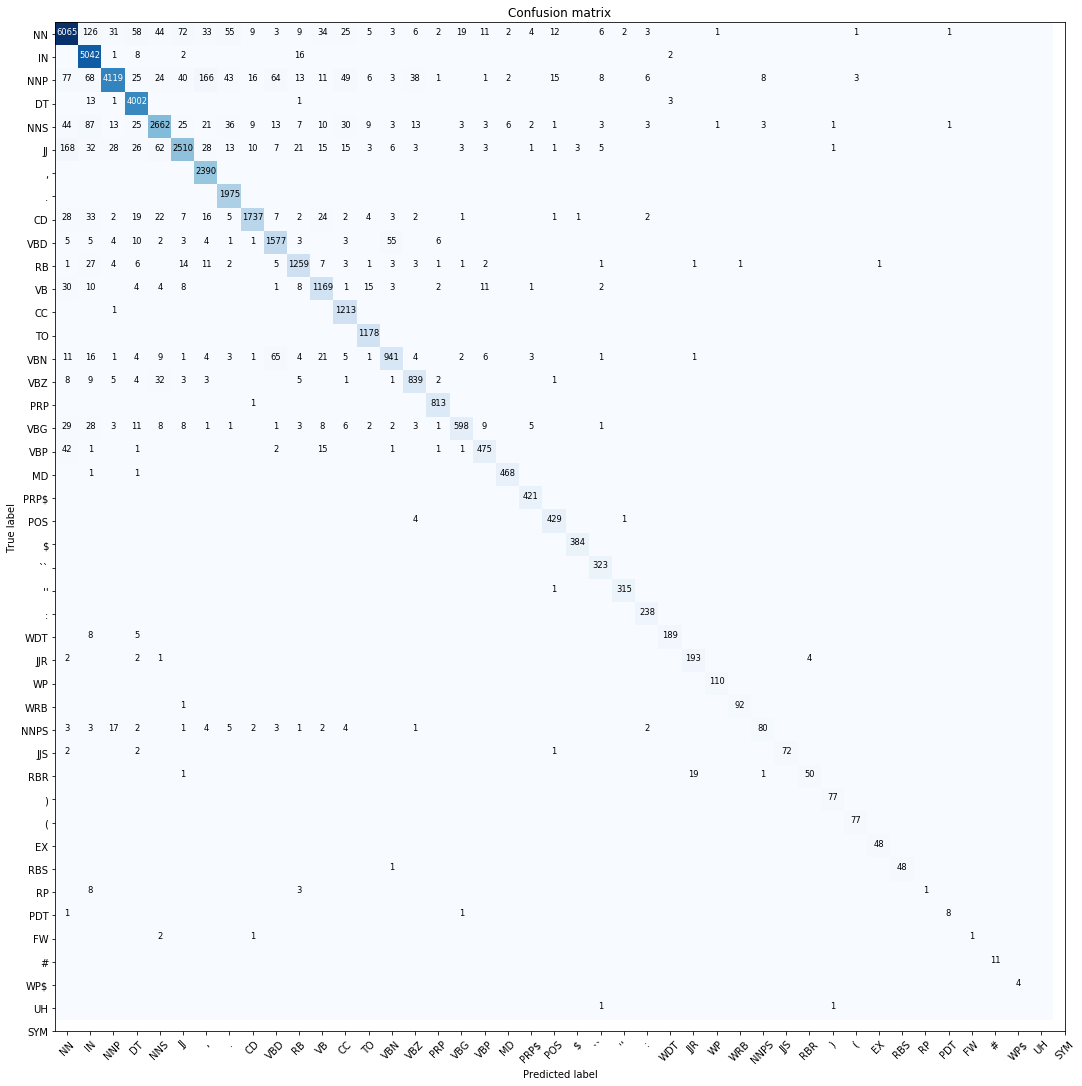

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    From scikit-learn examples.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] != 0:
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     size="smaller",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plot_confusion_matrix(C, enc2label.values())